# Análisis de Transporte Público & Machine Learning

Proyecto de análisis de transporte público aplicando visualización, análisis exploratorio y regresión multivariable a partir de estadísticas diarias de pasajeros del sistema SUBE (Argentina, 2023).

## Sobre esta notebook

Esta notebook corresponde a una versión “portfolio-ready” del proyecto, con el análisis ya ejecutado y documentado de forma clara y profesional.

Incluye todo el pipeline de análisis de datos, desde la inspección inicial y el procesamiento, hasta el modelado predictivo con evaluación de resultados y visualizaciones complementarias.

El objetivo es mostrar un enfoque estructurado para analizar comportamiento de uso en transporte público y predecir demanda futura a partir de series temporales multivariadas.

## Datos

- **SUBE (sube-2023.csv a sube-2023.csv)**: cantidad de pasajeros diarios por línea, empresa, tipo y jurisdicción de transporte. Se utilizaron múltiples años para enriquecer el análisis exploratorio.

- **SUBE (sube-2023-regresion.csv)**: desglose por línea de colectivos nacionales en el AMBA, con granularidad diaria.

Los datos fueron integrados, transformados y enriquecidos con nuevas columnas (día de la semana, ordinal, mes). Se filtraron observaciones preliminares y se normalizó el formato para el modelado.

Por cuestiones de licencia y tamaño, los archivos de datos no se incluyen en el repositorio.

In [1]:
import numpy as np
import pandas as pd
import seaborn.objects as so

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from formulaic import Formula

## Procesamiento de datos

In [2]:
dataSube = pd.read_csv("sube-2023.csv")
dataSube

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR
0,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,1,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,61,NO
1,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,2B,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,11,NO
2,2023-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 715M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1707,NO
3,2023-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,438,NO
4,2023-01-01,EMPRESA DE TRANSPORTE PERALTA RAMOS SACI,BS_AS_LINEA_512,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1189,NO
...,...,...,...,...,...,...,...,...,...,...
472286,2023-12-31,S.A TRANSPORTE CIUDAD DE RIO CUARTO,TRONCAL A,NO,COLECTIVO,MUNICIPAL,CORDOBA,RIO CUARTO,28,NO
472287,2023-12-31,S.A TRANSPORTE CIUDAD DE RIO CUARTO,TRONCAL B,NO,COLECTIVO,MUNICIPAL,CORDOBA,RIO CUARTO,38,NO
472288,2023-12-31,S.A TRANSPORTE CIUDAD DE RIO CUARTO,TRONCAL C,NO,COLECTIVO,MUNICIPAL,CORDOBA,RIO CUARTO,54,NO
472289,2023-12-31,S.A TRANSPORTE CIUDAD DE RIO CUARTO,TRONCAL D,NO,COLECTIVO,MUNICIPAL,CORDOBA,RIO CUARTO,52,NO


## Descripción general de los datos

Primero realizo una inspección inicial del dataset, revisando estructura, variables disponibles y valores faltantes.

In [3]:
w = dataSube.dtypes
w

DIA_TRANSPORTE     object
NOMBRE_EMPRESA     object
LINEA              object
AMBA               object
TIPO_TRANSPORTE    object
JURISDICCION       object
PROVINCIA          object
MUNICIPIO          object
CANTIDAD            int64
DATO_PRELIMINAR    object
dtype: object

In [4]:
dataSube['DIA_TRANSPORTE'] = pd.to_datetime(dataSube['DIA_TRANSPORTE'])

In [5]:
dataSube.dtypes

DIA_TRANSPORTE     datetime64[ns]
NOMBRE_EMPRESA             object
LINEA                      object
AMBA                       object
TIPO_TRANSPORTE            object
JURISDICCION               object
PROVINCIA                  object
MUNICIPIO                  object
CANTIDAD                    int64
DATO_PRELIMINAR            object
dtype: object

In [6]:
dataSube.insert(1,"FECHA_DIA",  dataSube['DIA_TRANSPORTE'].dt.day_name())
dataSube.insert(2,"FECHA_ORDINAL", dataSube['DIA_TRANSPORTE'].dt.dayofyear)
dataSube.insert(2,"FECHA_MES",  dataSube['DIA_TRANSPORTE'].dt.month)
dataSube

,DIA_TRANSPORTE,FECHA_DIA,FECHA_MES,FECHA_ORDINAL,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR
0,2023-01-01,Sunday,1,1,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,1,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,61,NO
1,2023-01-01,Sunday,1,1,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,2B,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,11,NO
2,2023-01-01,Sunday,1,1,EMPRESA BATAN S.A.,BS_AS_LINEA 715M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1707,NO
3,2023-01-01,Sunday,1,1,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,438,NO
4,2023-01-01,Sunday,1,1,EMPRESA DE TRANSPORTE PERALTA RAMOS SACI,BS_AS_LINEA_512,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1189,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
472286,2023-12-31,Sunday,12,365,S.A TRANSPORTE CIUDAD DE RIO CUARTO,TRONCAL A,NO,COLECTIVO,MUNICIPAL,CORDOBA,RIO CUARTO,28,NO
472287,2023-12-31,Sunday,12,365,S.A TRANSPORTE CIUDAD DE RIO CUARTO,TRONCAL B,NO,COLECTIVO,MUNICIPAL,CORDOBA,RIO CUARTO,38,NO
472288,2023-12-31,Sunday,12,365,S.A TRANSPORTE CIUDAD DE RIO CUARTO,TRONCAL C,NO,COLECTIVO,MUNICIPAL,CORDOBA,RIO CUARTO,54,NO
472289,2023-12-31,Sunday,12,365,S.A TRANSPORTE CIUDAD DE RIO CUARTO,TRONCAL D,NO,COLECTIVO,MUNICIPAL,CORDOBA,RIO CUARTO,52,NO


## Análisis exploratorio de los datos

A continuación realizo un análisis exploratorio para comprender mejor las relaciones entre variables, distribuciones y detectar posibles outliers.

In [7]:
datos_amba = dataSube[(dataSube['AMBA'] == 'SI')]
datos_amba = datos_amba.drop(["AMBA","DATO_PRELIMINAR","NOMBRE_EMPRESA", "MUNICIPIO", "PROVINCIA"], axis = 1).reset_index(drop = True)
orden_columnas = ["DIA_TRANSPORTE", "FECHA_DIA","FECHA_MES", "FECHA_ORDINAL", "JURISDICCION", "LINEA", "CANTIDAD", "TIPO_TRANSPORTE"]
datos_amba = datos_amba[orden_columnas]
datos_amba = datos_amba.rename(columns = str.lower)
datos_amba = datos_amba.rename(columns = {"cantidad" : "pasajeros", "dia_transporte": "fecha"})
datos_amba.head()

,fecha,fecha_dia,fecha_mes,fecha_ordinal,jurisdiccion,linea,pasajeros,tipo_transporte
0,2023-01-01,Sunday,1,1,MUNICIPAL,1,61,COLECTIVO
1,2023-01-01,Sunday,1,1,MUNICIPAL,2B,11,COLECTIVO
2,2023-01-01,Sunday,1,1,PROVINCIAL,BS_AS_LINEA_326,438,COLECTIVO
3,2023-01-01,Sunday,1,1,MUNICIPAL,BS_AS_LINEA_514,3067,COLECTIVO
4,2023-01-01,Sunday,1,1,MUNICIPAL,BS_AS_LINEA_522,332,COLECTIVO


## Preparación de los datos

En esta sección realizo el preprocesamiento necesario para preparar los datos para el modelado: imputación, codificación y escalado.

In [8]:
totalPasajeros = datos_amba["pasajeros"].sum()
pasajeros_por_transporte = datos_amba.groupby("tipo_transporte")["pasajeros"].sum()
proporcionPasajeros = (pasajeros_por_transporte / totalPasajeros).to_dict()
proporcionPasajeros

{'COLECTIVO': 0.8376769283969979,
 'SUBTE': 0.0680835594333361,
 'TREN': 0.09423951216966597}

In [9]:
tuplas = []
for i in range(1,13):
    subtes = datos_amba[(datos_amba["tipo_transporte"] == "SUBTE") & (datos_amba["fecha_mes"] == i)]
    w = subtes.groupby("linea")["pasajeros"].sum()
    w_index = w.index
    w_list = w.to_list()
    for u in range(len(w_index)):
        t = (i,w_index[u], w_list[u])
        tuplas.append(t)

tupla_maxima = max(tuplas, key=lambda x: x[2])
tupla = (tupla_maxima[0], tupla_maxima[1])
print("El mes y la linea de subte donde viajo más gente es:", tupla)

El mes y la linea de subte donde viajo más gente es: (8, 'LINEA_B')


In [10]:
dias_habiles = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
datos_amba_dias_habiles = datos_amba[datos_amba["fecha_dia"].isin(dias_habiles)]
desvioEstandar_por_dia = datos_amba_dias_habiles.groupby("fecha_dia")["pasajeros"].std()
dia_menor_desvio = desvioEstandar_por_dia.idxmin()
print("El día hábil con menor desvio estandar en cantidad de pasajeros es", dia_menor_desvio)

El día hábil con menor desvio estandar en cantidad de pasajeros es Monday


## Análisis Exploratorio

## Modelado predictivo

En esta sección desarrollo un enfoque de modelado supervisado para predecir la cantidad de pasajeros diarios en una línea específica de colectivos del AMBA, utilizando como variables predictoras la cantidad de pasajeros en otras líneas del sistema.

Para ello, construyo un DataFrame donde cada fila representa un día del año y cada columna corresponde a una línea de colectivos nacional en el área AMBA. La variable objetivo es la cantidad de pasajeros de la línea **BSAS_LINEA_009**.

Primero filtro las líneas relevantes y organizo los datos en formato adecuado para aplicar modelos de regresión.

Luego elimino aquellas columnas que presentan datos faltantes para asegurar consistencia durante el entrenamiento.

Posteriormente, propongo **tres modelos de regresión** utilizando diferentes subconjuntos de variables predictoras (cada uno usando solo cinco líneas de colectivo como features). Para seleccionar las líneas utilizadas en cada modelo, considero criterios como su volumen total de pasajeros, su correlación con la línea objetivo o su variabilidad temporal.

Uno de los modelos implementados es una regresión Ridge. En ese caso, optimizo el hiperparámetro de regularización α mediante validación cruzada.

Finalmente, comparo el desempeño de los tres modelos aplicando un esquema de validación y selecciono aquel con mejor rendimiento para su evaluación final. Incluyo además la fórmula final del modelo elegido.

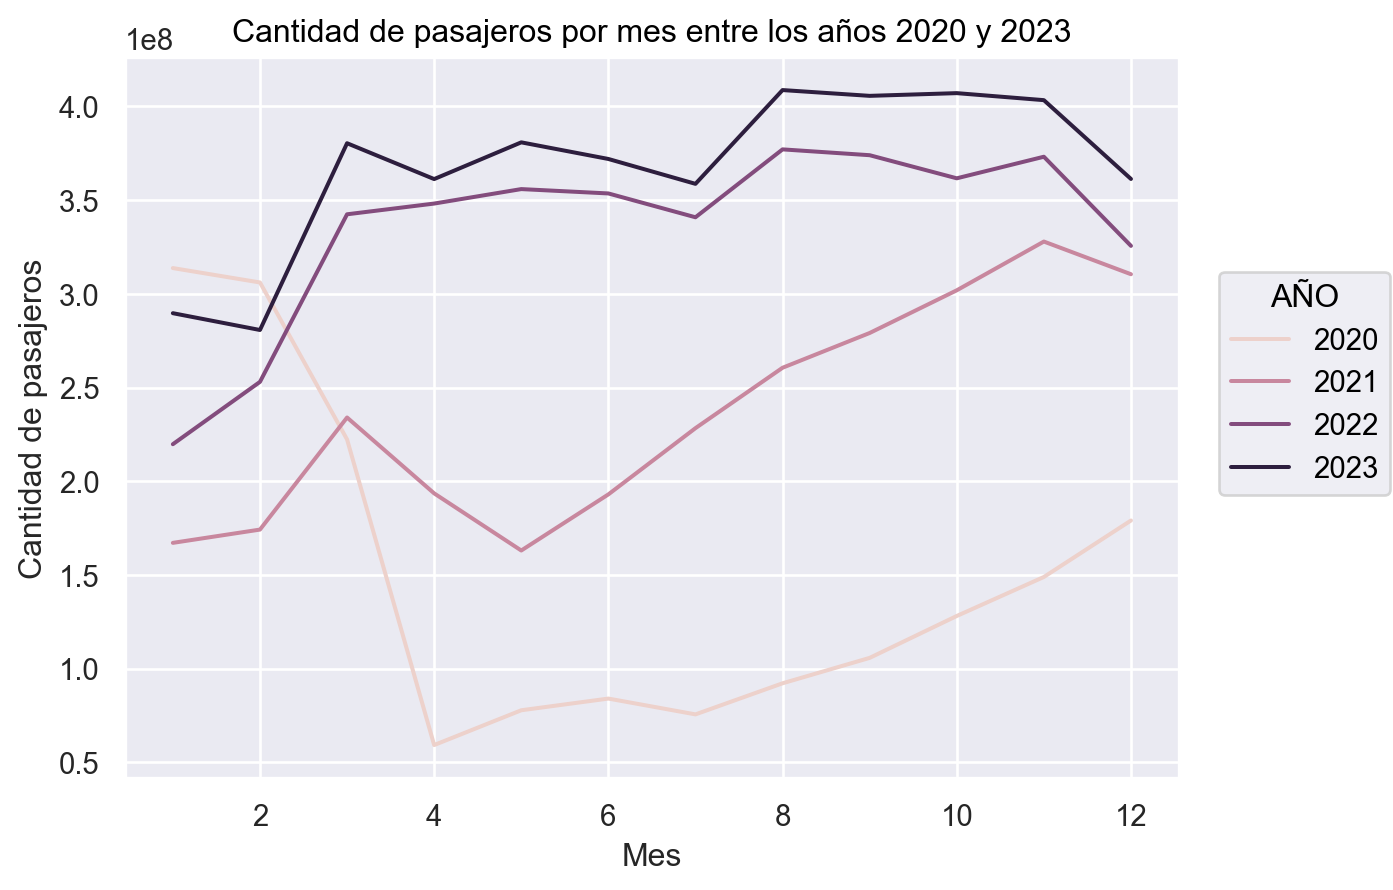

In [11]:
sube2023 = pd.read_csv("sube-2023.csv")
sube2022 = pd.read_csv("dat-ab-usos-2022.csv")
sube2021 = pd.read_csv("dat-ab-usos-2021.csv")
sube2020 = pd.read_csv("dat-ab-usos-2020.csv")
subesCombinadas = pd.concat([sube2020,sube2021,sube2022,sube2023])
subesCombinadas['DIA_TRANSPORTE'] = pd.to_datetime(subesCombinadas['DIA_TRANSPORTE'])
subesCombinadas.insert(1,"AÑO",  subesCombinadas['DIA_TRANSPORTE'].dt.year)
subesCombinadas.insert(1,"MES",  subesCombinadas['DIA_TRANSPORTE'].dt.month)
SumaSubesCombinadas = subesCombinadas.groupby(["MES", "AÑO"], as_index=False)["CANTIDAD"].sum()
(
    so.Plot(data=SumaSubesCombinadas, x = "MES", y = "CANTIDAD", color = "AÑO")
    .add(so.Line())
    .label(title="Cantidad de pasajeros por mes entre los años 2020 y 2023", x = "Mes", y = "Cantidad de pasajeros")
)

In [12]:
media_pasajeros2020 = sube2020["CANTIDAD"].mean()
media_pasajeros2021 = sube2021["CANTIDAD"].mean()
media_pasajeros2022 = sube2022["CANTIDAD"].mean()
media_pasajeros2023 = sube2023["CANTIDAD"].mean()
print("Media de cada año: 2020=", media_pasajeros2020, "2021=", media_pasajeros2021, "2022 =", media_pasajeros2022, "2023 =", media_pasajeros2023)

Media de cada año: 2020= 5026.1488806263105 2021= 6898.916163392135 2022 = 9162.127442031971 2023 = 9336.92745362499


En el gráfico "Cantidad de pasajeros por mes entre los años 2020 y 2023" está visible la diferencia que hubo en términos de cantidad de pasajeros que usaron el transporte público entre 2020 y 2023. La gran caída de pasajeros para abril de 2020 se debe a la cuarentena, que fue tomada como medida para prevenir la expansión de la pandemia del covid-19. En el gráfico se muestra también como a medida que se fue liberando la misma la cantidad de pasajeros fue de a poco aumentando. En 2021, que todavía estaba en pie la pandemia pero que todo estaba ya más liberado, se ve una gran diferencia en cantidad de pasajeros respecto al del 2022 y 2023, años en los que ya se había retornado a la "normalidad". 
Al calcular la media de cada año también se veía la diferencia en cantidad de pasajeros que usó el transporte público cada año que expresa el gráfico.
Si no centramos solo en los años 2022 y 2023, aunque tengan diferencia en cantidad de pasajero (en 2023 siempre huieron más pasajeros que en 2022) podemos ver como más o menos hacen un mismo "recorrido". En el mes 3 (marzo) hacen un salto, es decir que son muchos más los que toman el transporte público con respecto al mes anterior. Luego, en ambos años disminuye la cantidad total de pasajeros para el mes 7 (julio), para volver a aumentar considerablemente en el siguiente mes, agosto. Finalmente, ambas curvas vuelven a disminuir un poco en diciembre. El comportamiento similar en las curvas de 2022 y 2023 en los meses antes mencionados puede estar evidenciando cómo varía la cantidad total de personas que usan el transporte público según sean epocas de recesos o no, como pueden ser julio y diciembre que tienen por ejemplo receso invernal y finalización de clases. En contraposición, en los meses de marzo y agosoto, cuando finalizan las vacaciones y se retorna a la rutina se ve un incremento en la cantidad de pasajeros.

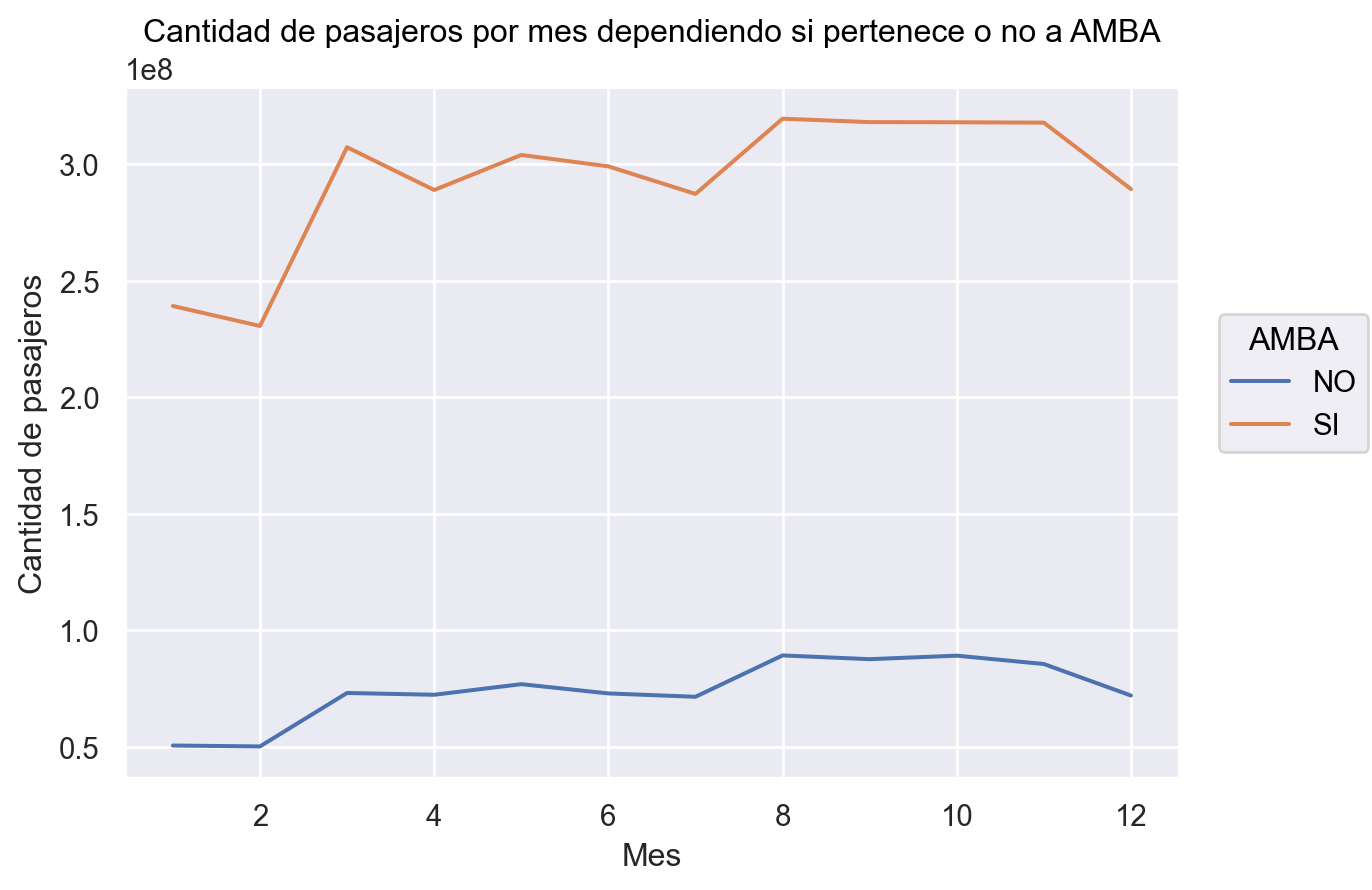

In [13]:
SumaMesAmba = dataSube.groupby(["FECHA_MES", "AMBA"], as_index=False)["CANTIDAD"].sum()
(
    so.Plot(SumaMesAmba, x ="FECHA_MES", y = "CANTIDAD", color= "AMBA")
    .add(so.Line())
    .label(title = "Cantidad de pasajeros por mes dependiendo si pertenece o no a AMBA", x= "Mes", y= "Cantidad de pasajeros")
)

En este gráfico se muestra la cantidad de pasajeros en cada mes segun si pertenecen a AMBA o no, se ve que en AMBA hubo una mayor utilización del transporte público. Además ambas curvas siguen más o menos la tendencia que veniamos analizando de aumento y disminución en cantidad de pasajeros segun si es epoca de recesos o no.

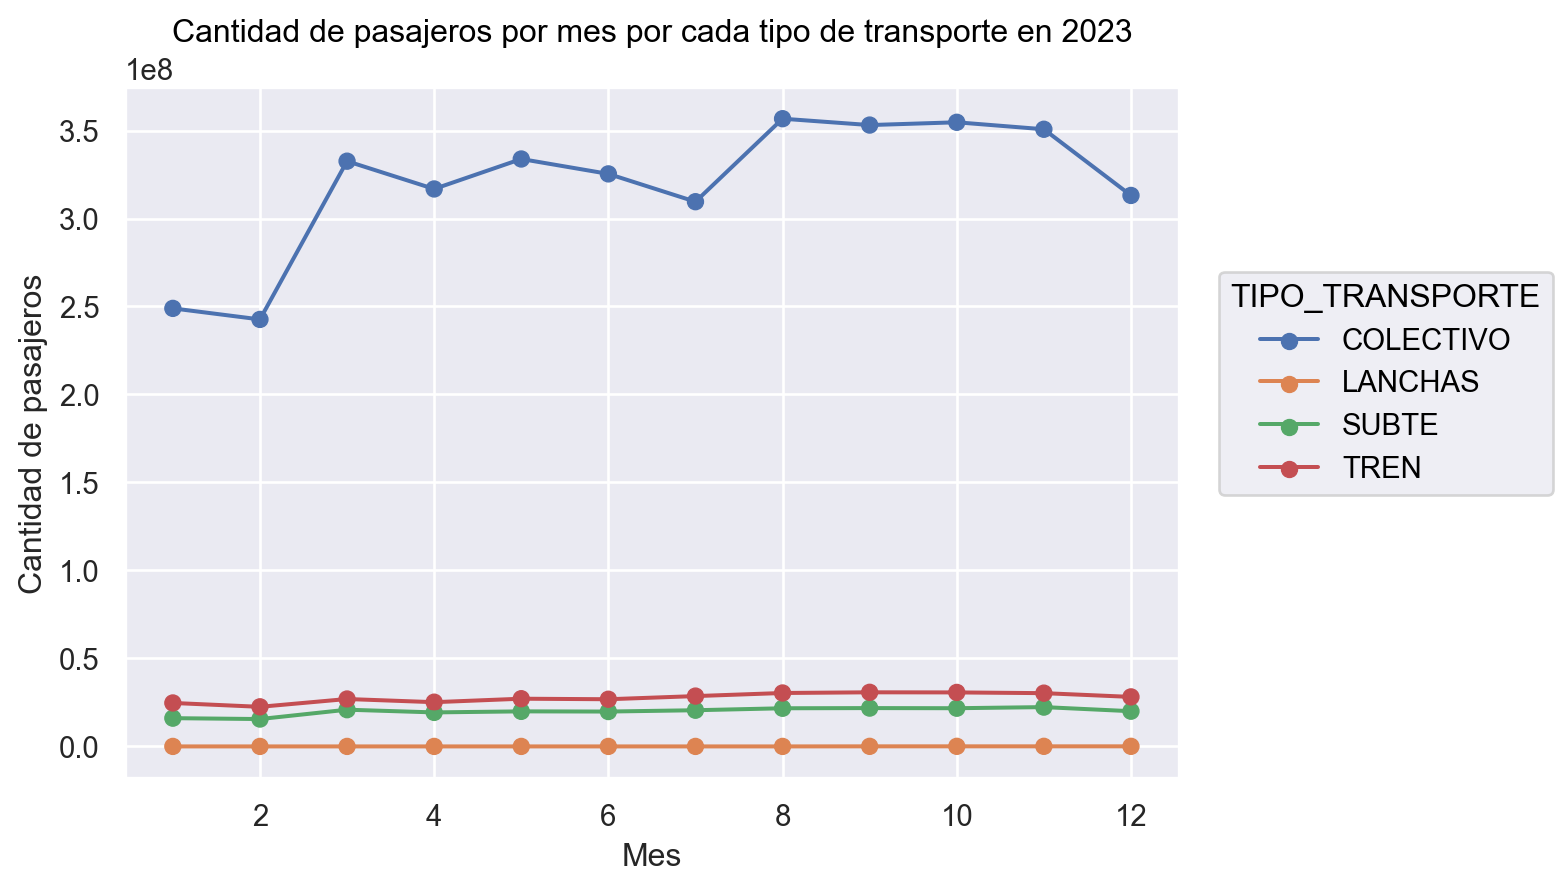

In [14]:
dataSumadaMES = dataSube.groupby(["FECHA_MES", "TIPO_TRANSPORTE"], as_index=False)["CANTIDAD"].sum()
(
    so.Plot(dataSumadaMES, x="FECHA_MES", y="CANTIDAD", color = "TIPO_TRANSPORTE")
    .add(so.Dot())
    .add(so.Line())
    .label(title= "Cantidad de pasajeros por mes por cada tipo de transporte en 2023", x = "Mes", y = "Cantidad de pasajeros")
)

Este gráfico muestra la utilización de cada tipo de medio de transporte en los meses 2023, lo que nos llama la atención es que el subte y el tren son constantes en la cantidad de pasajeros que los eligen sin importar en que mes esten (si, hay alguna variacion pero no son tan notorias), sin embargo los colectivos, más alla de simepre tener muchisimos más pasajeros, fluctua similarmente a la curva del 2023 del gráfico anterior. Primero como es tanto mayor la gente que toma el colectivo a la que usa otro tipo de transporte, no es sorpresa que la curva del colectivo "condicione" a la curva total de pasajeros. Segundo se puede pensar que el análisis hecho anteriormente sobre los meses en los que hay recesos o no y la cantidad de pasajeros en ellos solo vale para los colectivos, ya que en los trenes y subtes no hay tanto cambio, si se ve un pequeño aumento y disminución en marzo y diciembre/enero respectivamente. Esto puede indicar que las personas que suelen tomarse el tren o subte no tienen receso a mitad de año.

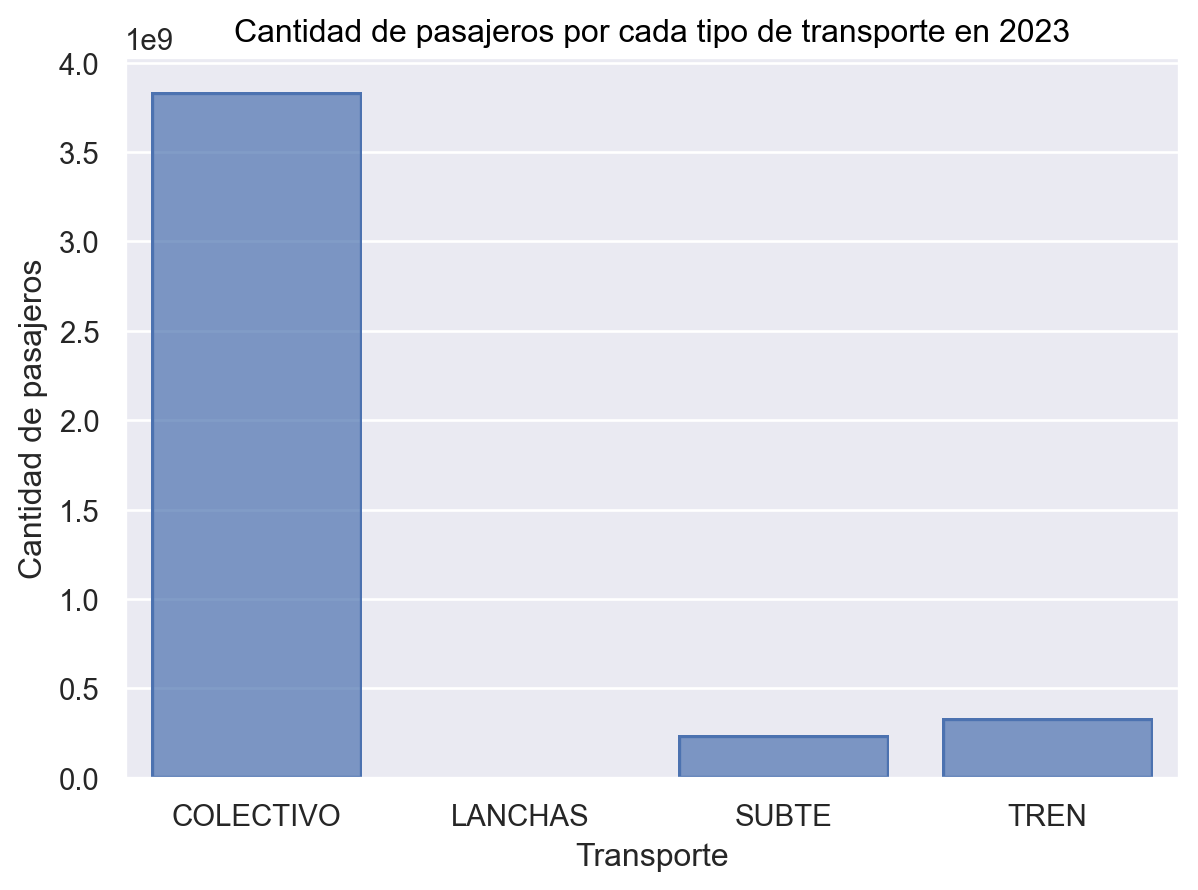

In [15]:
data = dataSube.groupby("TIPO_TRANSPORTE")["CANTIDAD"].sum().reset_index()
(
    so.Plot(data, x="TIPO_TRANSPORTE", y="CANTIDAD")
    .add(so.Bar())
    .label(title="Cantidad de pasajeros por cada tipo de transporte en 2023", x = "Transporte", y= "Cantidad de pasajeros")
)

Este gráfico de barras muestra la cantidad de pasajeros totales en 2023 para cada medio de transporte. En el gráfico anterior ya habíamos visto que en todos los meses era muy notoria la diferencia en cantidad de pasajeros que usan el colectivo con respecto a los que usan tren y/o subte. Pensamos que esta diferencia se puede deber a que hay muchisimas más lineas de colectivos que de trenes o subtes, así que hay multiples opciones de como salir o llegar a un lugar. Además la frecuencia con la que pasa cada medio de transporte también influye en la cantidad de pasajeros que pueden tomar cada una.

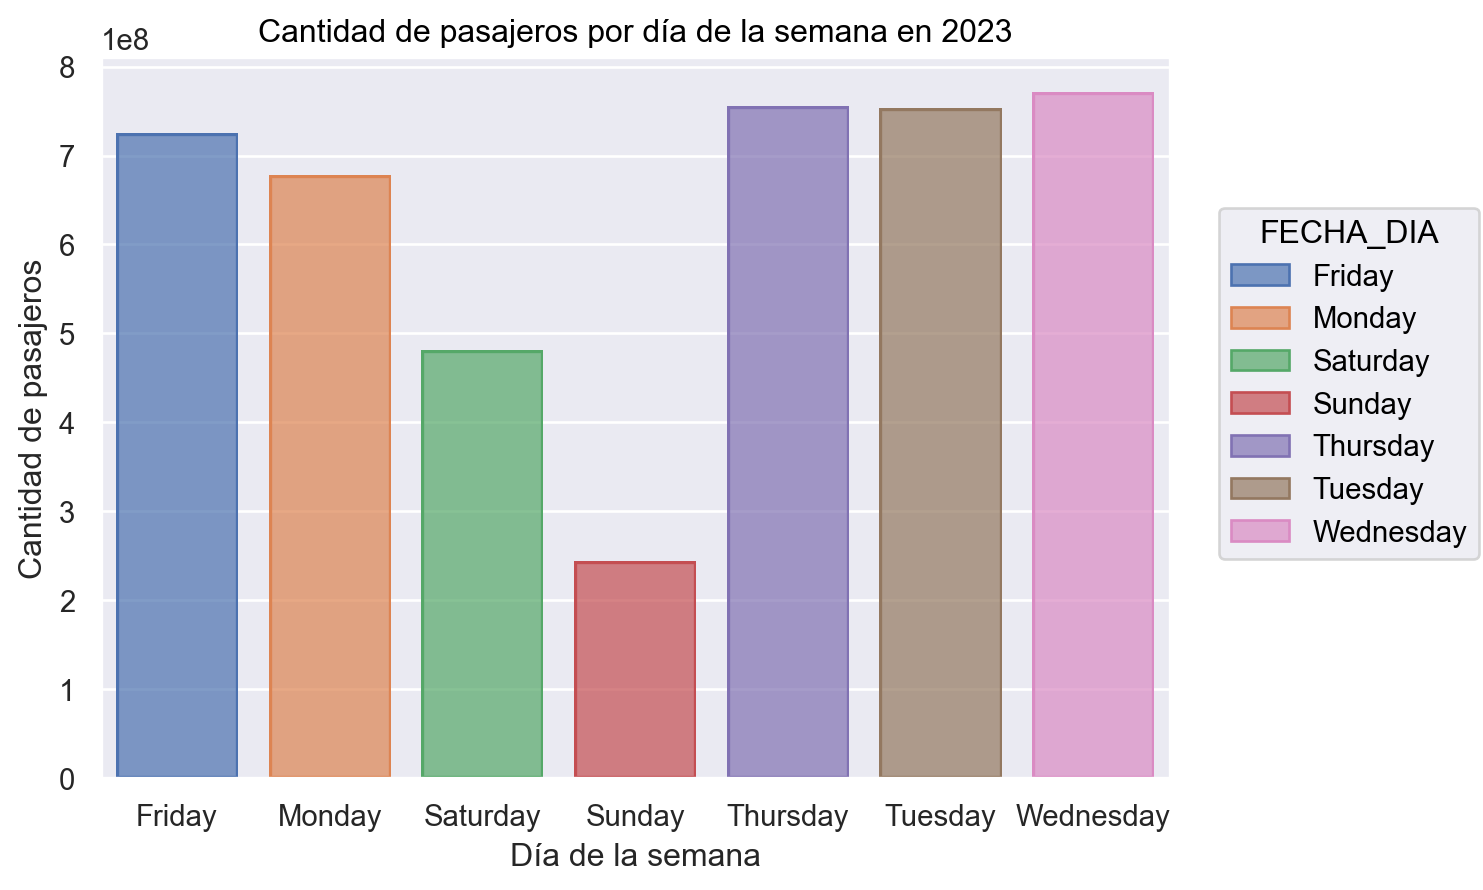

In [16]:
data = dataSube.groupby("FECHA_DIA")["CANTIDAD"].sum().reset_index()
(
    so.Plot(data, x="FECHA_DIA", y="CANTIDAD")
    .add(so.Bar(), color = "FECHA_DIA")
    .label(title="Cantidad de pasajeros por día de la semana en 2023", x = "Día de la semana", y= "Cantidad de pasajeros")
)

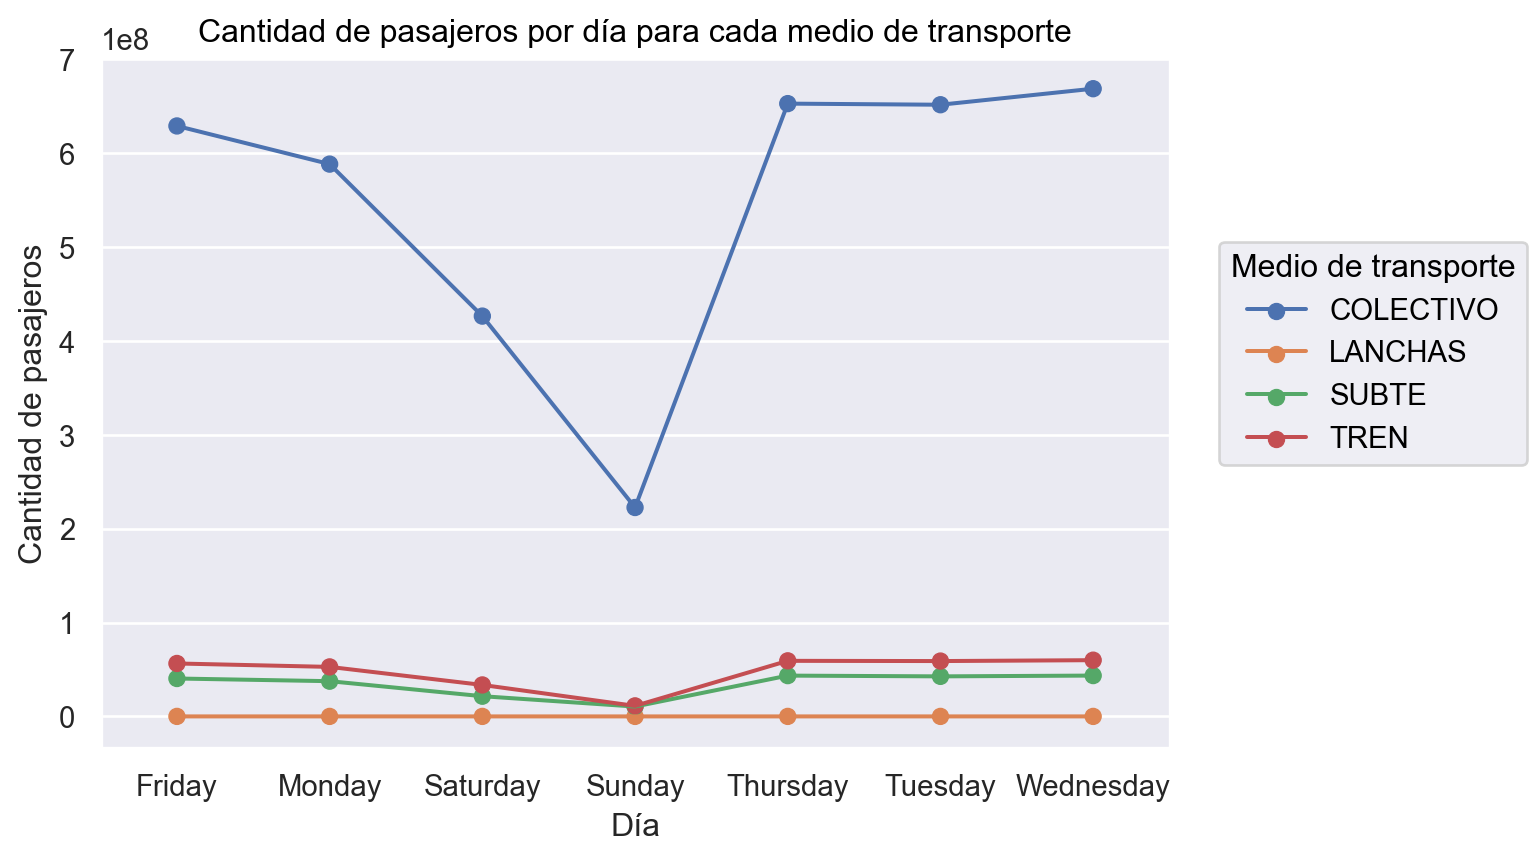

In [17]:
dataSumada = dataSube.groupby(["FECHA_DIA", "TIPO_TRANSPORTE"], as_index=False)["CANTIDAD"].sum()
(
    so.Plot(dataSumada, x ="FECHA_DIA", y="CANTIDAD", color="TIPO_TRANSPORTE")
    .add(so.Dot())
    .add(so.Line())
    .label(title= "Cantidad de pasajeros por día para cada medio de transporte", x="Día", y="Cantidad de pasajeros", color="Medio de transporte")
)

Estos últimos dos graficos, muestran la cantidad de pasajeros por día de semana, el segundo adémas est aseparado por tipo de transporte. En ambos se ve como de lunes a miércoles va auemntando la cantidad de pasajeros, entre miércoles y viernes baja. Finalmente los sábados y especialmente los domingos tiene una gran disminución en cantidad de pasajeros que se debe seguramente a que el sábado y domingo son dias dentro del fin de semana. El segundo gráfico nos generó curiosidad si en todos los medios de transporte iban a tener un comportamiento similar, sin importar si tienen mayor o menor cantidad de pasajeros, y sí, en todos los transportes se ve la caída en cantidad de pasajeros para los dias de fin de semana.

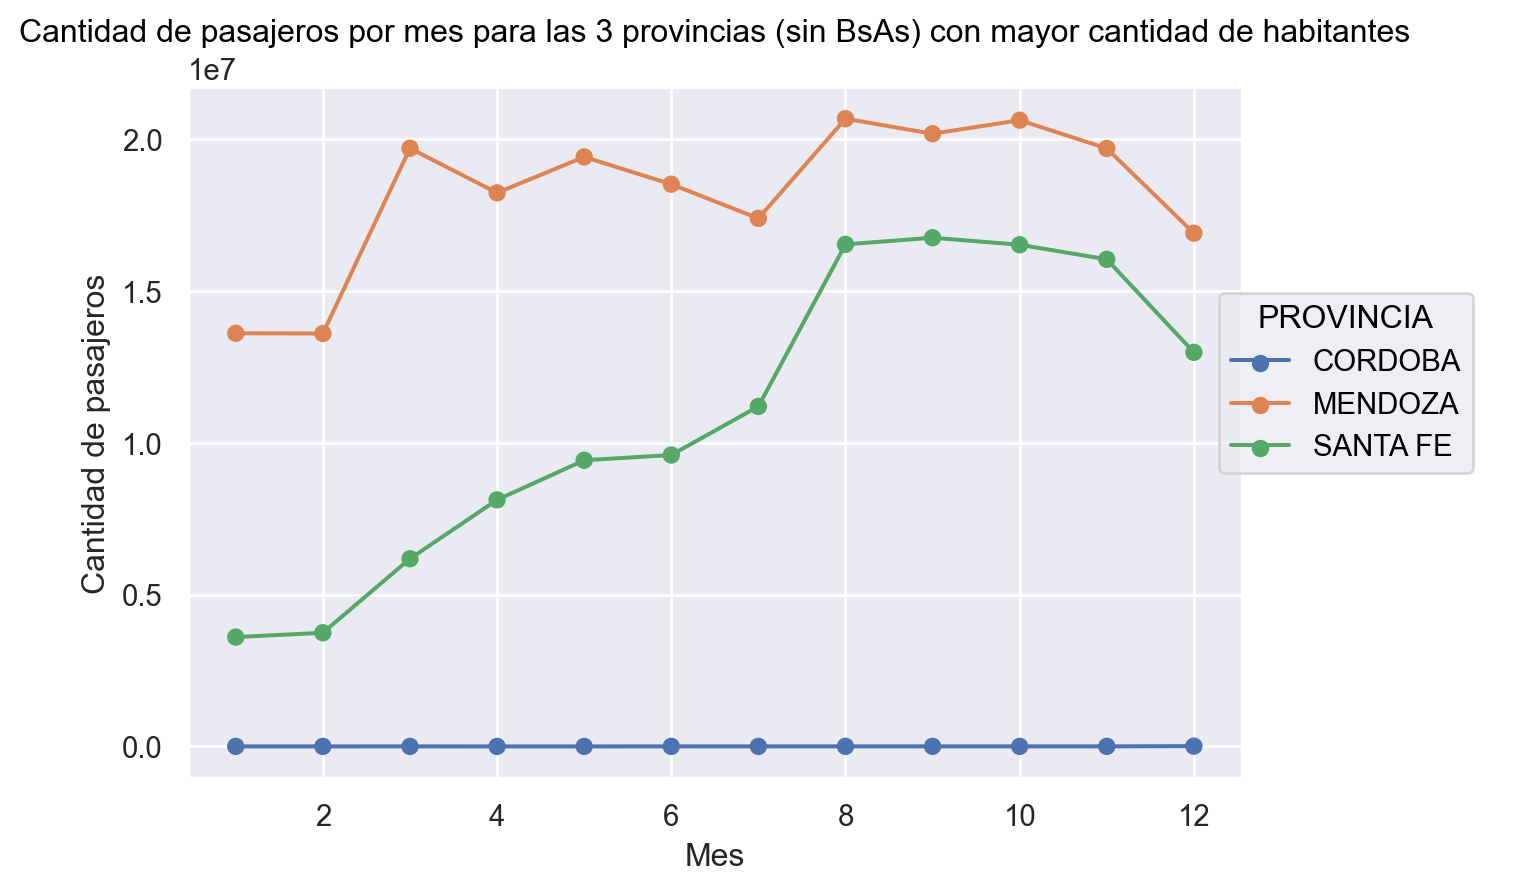

In [18]:
# Vamos a ver como es el uso del transporte público en las 3 provincias con mayor cantidad de habitantes segun el Censo 2022, sin contar Buenos Aires.
provincias_mayorpob = ["CORDOBA","MENDOZA", "SANTA FE"]
sube_filtrado = dataSube[dataSube['PROVINCIA'].isin(provincias_mayorpob)]

SumaProvincias = sube_filtrado.groupby(["FECHA_MES", "PROVINCIA"], as_index=False)["CANTIDAD"].sum()
(
    so.Plot(SumaProvincias, x ="FECHA_MES", y="CANTIDAD", color="PROVINCIA")
    .add(so.Dot())
    .add(so.Line())
    .label(title= "Cantidad de pasajeros por mes para las 3 provincias (sin BsAs) con mayor cantidad de habitantes", x="Mes", y="Cantidad de pasajeros", color="PROVINCIA")
)

Este gráfico muestra la cantidad de pasajeros que usaron el transporte público a lo largo del 2023 en las provincias: Córdoba, Mendoza y Santa Fe. Elegimos analizar más profundamente estas provincias ya que son las 3 provincias, además de Buenos Aires que más habitantes tienen según el Censo realizado en 2022. 
Lo primero que llama la atención es la curva de Córdoba ya que pareciera que no utilizaron el transporte público en todo el año, así que luego haremos un gráfico para poder observar cómo fue la utilización del transporte público en esta provincia.
Lo segundo que nos llama la atención es que la curva de Mendoza tiene un comportamiento similar, en tendencias de aumento y disminución de cantidad de pasajeros, a la curva con la suma total del país en 2023. Pero por otro lado, la curva de Santa Fe tiene un comportamiento un tanto distinto, su cantidad de pasajeros fue aumentando lentamente hasta julio, y de julio a Agosto hizo su mayor aumento, luego más o menos se mantuvo y finalmente decendió para diciembre.

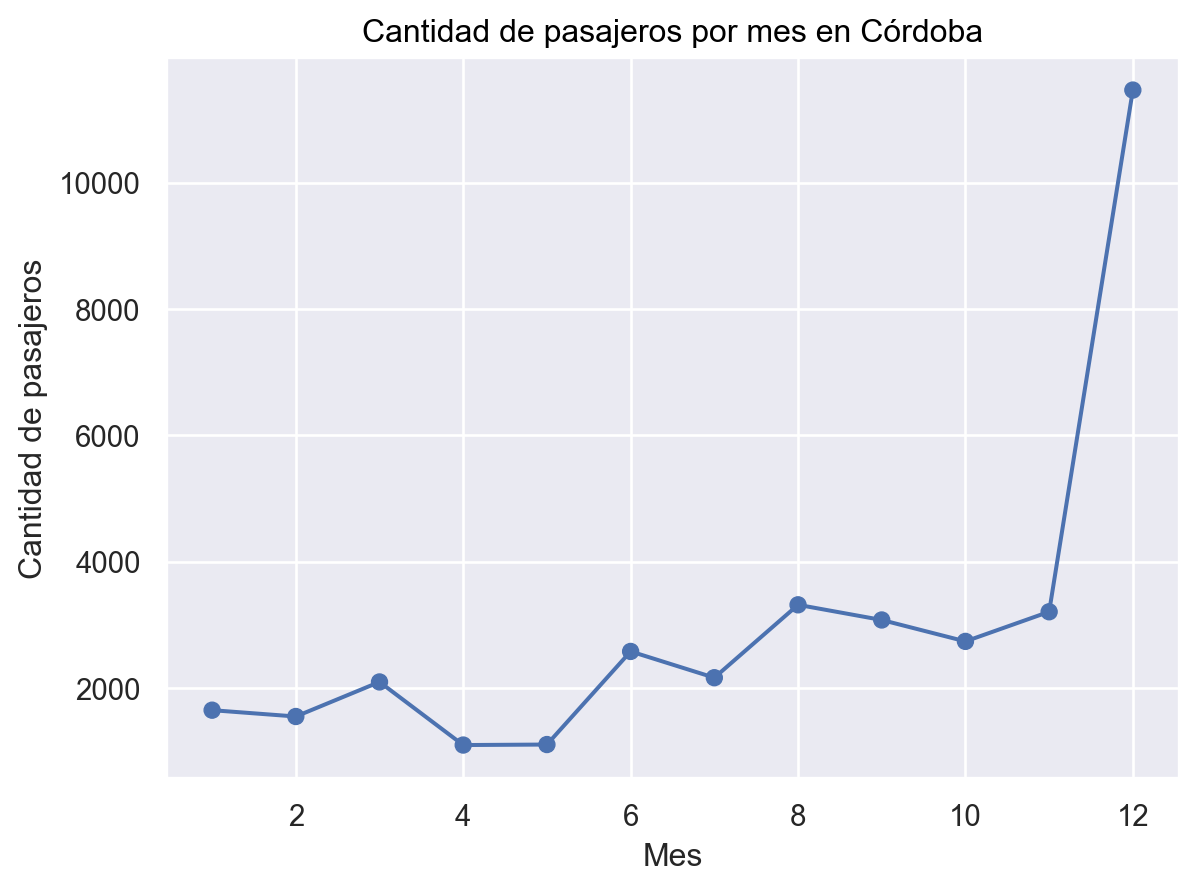

In [19]:
sube_cordoba = dataSube[dataSube['PROVINCIA'] == "CORDOBA"]

SumaCordoba = sube_cordoba.groupby(["FECHA_MES"], as_index=False)["CANTIDAD"].sum()
(
    so.Plot(SumaCordoba, x ="FECHA_MES", y="CANTIDAD")
    .add(so.Dot())
    .add(so.Line())
    .label(title= "Cantidad de pasajeros por mes en Córdoba", x="Mes", y="Cantidad de pasajeros")
)

Este es el gráfico de Córdoba, en el gráfico anterior no parecia tener actividad porque a comparación de las otras dos provincias en Córdoba la cantidad de pasajeros en el transporte público es casi insignificante (más teniendo en cuenta que es, después de Buenos Aires, la provincia con más habitantes), hasta noviembre está por debajo de los 5000 (cinco mil) pasajeros. Las causas de esta baja cantidad de pasajeros pueden ser diversas. Por esto investigamos un poco y encontramos una noticia del 11 de julio del 2023 del diario "La Voz" que dice: "Córdoba se consolidó como la segunda provincia con más vehículos en el país, después de la provincia de Buenos Aires (5,68 millones) y por encima de la ciudad de Buenos Aires (1,39 millones)", por lo que pensamos que una de las razones por las que hay pocos pasajeros puede ser la gran cantidad de vehículos que tiene esta provincia.
Además llama la atención el comportamiento de la curva ya que al contrario de todas, esta en diciembre tiene un gran aumento de pasajeros mientras que en el resto para ese mes disminuía la cantidad de pasajeros.

In [20]:
media_cordoba = sube_cordoba["CANTIDAD"].mean()
mediana_cordoba = sube_cordoba["CANTIDAD"].median()
print("La media es:", media_cordoba, "y su mediana es:", mediana_cordoba)

La media es: 44.264127764127764 y su mediana es: 37.5


Este cálculo de media y miediana para Córdoba primero reflejan ambas la baja cantidad de pasajeros y luego sos numeros difieren un poco ya que la media esta más condicionada por los outliers, entonces si un día hubieron muchos más habitantes hizo que est asea un poco más baja.

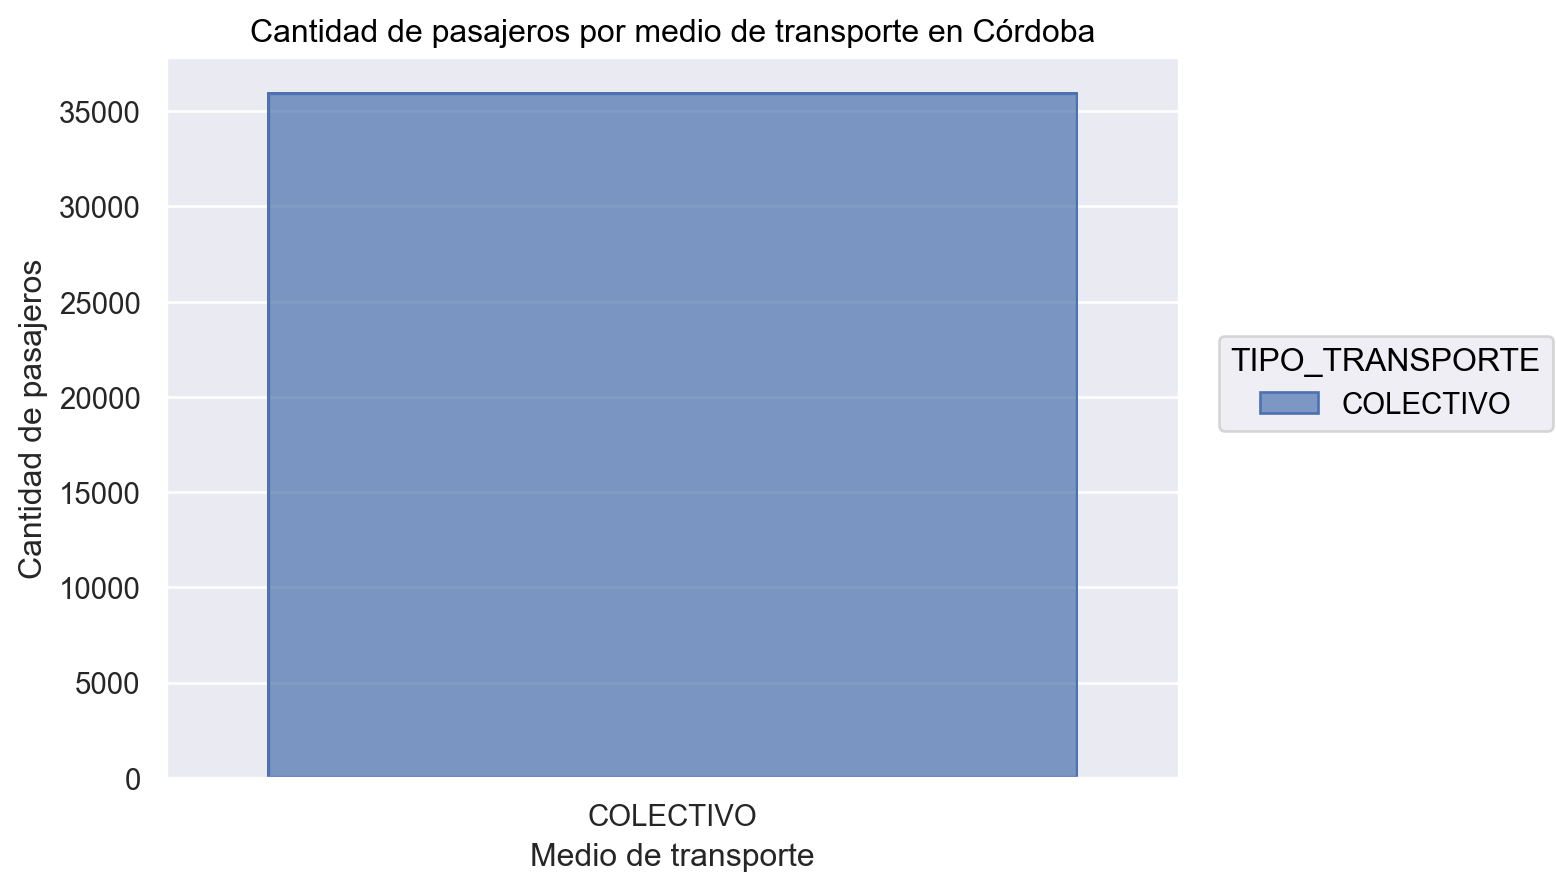

In [21]:
SumaCordoba = sube_cordoba.groupby(["TIPO_TRANSPORTE"], as_index=False)["CANTIDAD"].sum()
(
    so.Plot(SumaCordoba, x ="TIPO_TRANSPORTE", y="CANTIDAD")
    .add(so.Bar(), color = "TIPO_TRANSPORTE")
    .label(title= "Cantidad de pasajeros por medio de transporte en Córdoba", x="Medio de transporte", y="Cantidad de pasajeros")
)

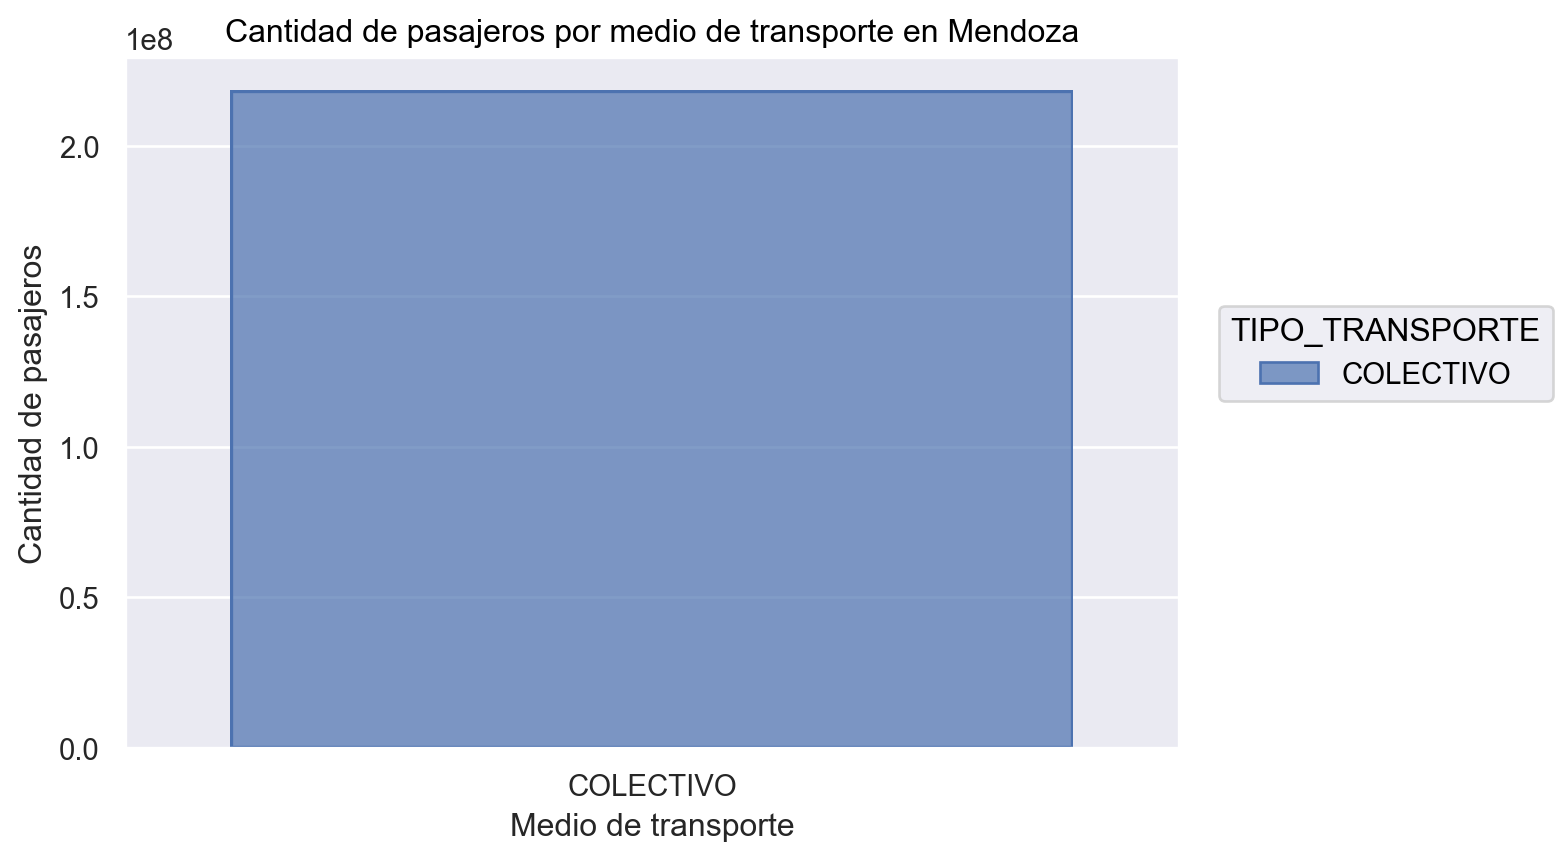

In [22]:
sube_mendoza = dataSube[dataSube['PROVINCIA'] == "MENDOZA"]
SumaMendoza = sube_mendoza.groupby(["TIPO_TRANSPORTE"], as_index=False)["CANTIDAD"].sum()
(
    so.Plot(SumaMendoza, x ="TIPO_TRANSPORTE", y="CANTIDAD")
    .add(so.Bar(), color = "TIPO_TRANSPORTE")
    .label(title= "Cantidad de pasajeros por medio de transporte en Mendoza", x="Medio de transporte", y="Cantidad de pasajeros")
)

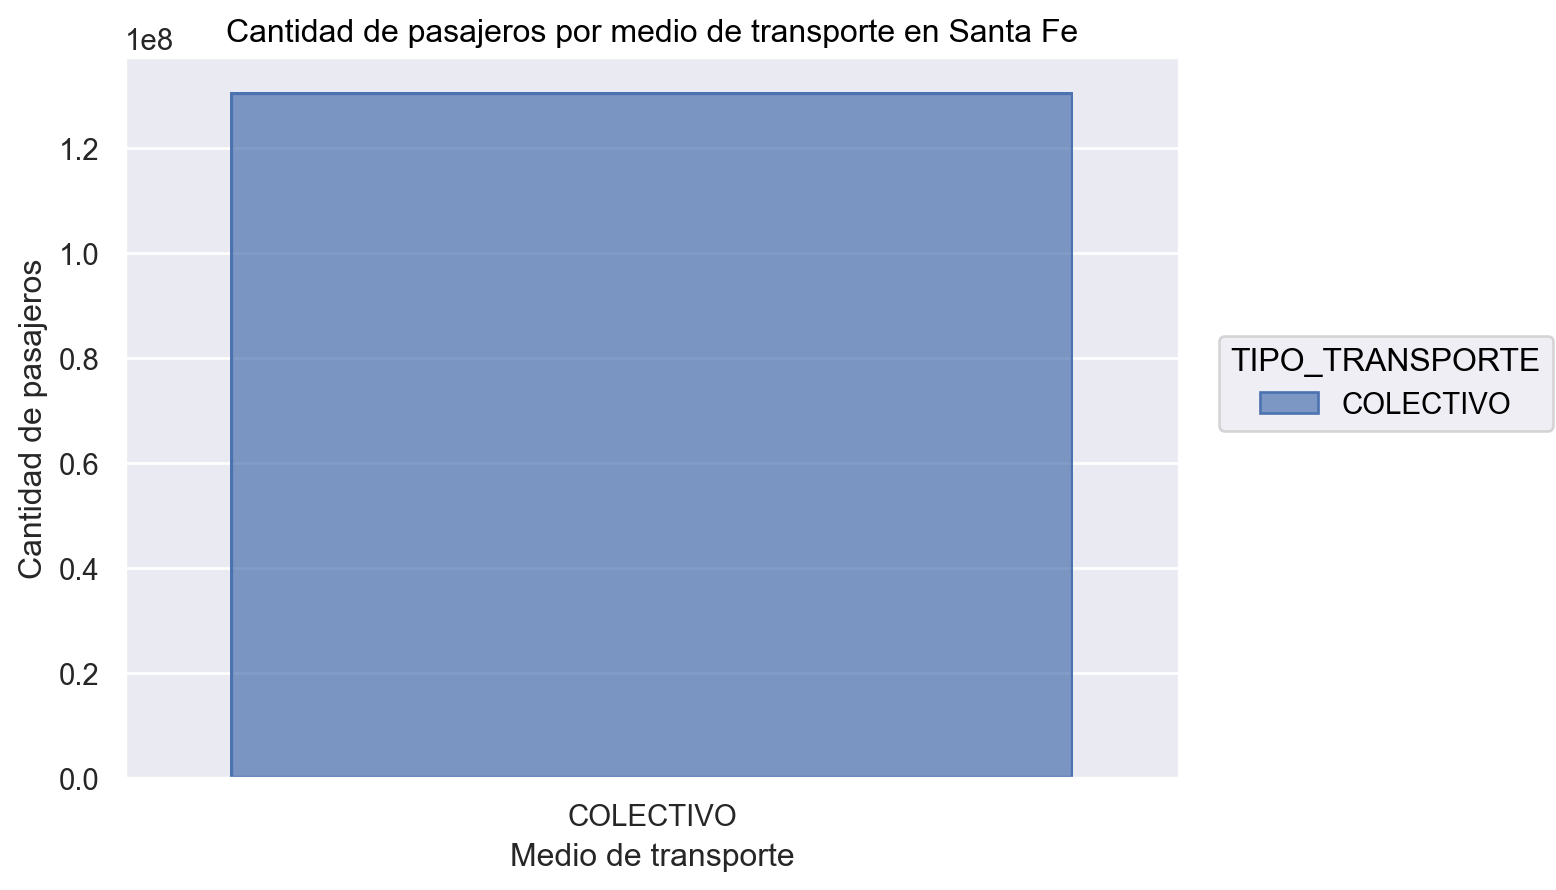

In [23]:
sube_santafe = dataSube[dataSube['PROVINCIA'] == "SANTA FE"]
SumaSantaFe = sube_santafe.groupby(["TIPO_TRANSPORTE"], as_index=False)["CANTIDAD"].sum()
(
    so.Plot(SumaSantaFe, x ="TIPO_TRANSPORTE", y="CANTIDAD")
    .add(so.Bar(), color = "TIPO_TRANSPORTE")
    .label(title= "Cantidad de pasajeros por medio de transporte en Santa Fe", x="Medio de transporte", y="Cantidad de pasajeros")
)

Estos últimos gráficos muestran que el total de los pasajeros cordobeces, mendocinos y santafecinos viajan en colectivo, esto debe ser así porque no debe haber otro medio de transporte. Esto podría explicar una de las causas por las que el interior tiene poca cantidad de pasajeros, no tiene tantas opciones de medio de transporte y por ahí las lineas de colectivo que tiene no se adaptan a las necesidades de todos. Esto sumado a que son muchos menos habitantes que en Buenos Aires, y puede ser que muchos de los trabajadores lo hagan en campos.
Siendo las provincias analizadas las que más habitantes tienen imaginamos que no en muchas del resto hayan más medios de transporte además del colectivo. Habría que analizar si en el interior existe la necesidad de proveer más variedad de transporte público que pueda facilitarle más la vida a la gento o si con lo que tienen ya estan cubiertas todas las necesidades.

## Modelado predictivo

En esta sección desarrollo un enfoque de modelado supervisado para predecir la cantidad de pasajeros diarios en una línea específica de colectivos del AMBA, utilizando como variables predictoras la cantidad de pasajeros en otras líneas del sistema.

Para ello, construyo un DataFrame donde cada fila representa un día del año y cada columna corresponde a una línea de colectivos nacional en el área AMBA. La variable objetivo es la cantidad de pasajeros de la línea **BSAS_LINEA_009**.

Primero filtro las líneas relevantes y organizo los datos en formato adecuado para aplicar modelos de regresión.

Luego elimino aquellas columnas que presentan datos faltantes para asegurar consistencia durante el entrenamiento.

Posteriormente, propongo **tres modelos de regresión** utilizando diferentes subconjuntos de variables predictoras (cada uno usando solo cinco líneas de colectivo como features). Para seleccionar las líneas utilizadas en cada modelo, considero criterios como su volumen total de pasajeros, su correlación con la línea objetivo o su variabilidad temporal.

Uno de los modelos implementados es una regresión Ridge. En ese caso, optimizo el hiperparámetro de regularización α mediante validación cruzada.

Finalmente, comparo el desempeño de los tres modelos aplicando un esquema de validación y selecciono aquel con mejor rendimiento para su evaluación final. Incluyo además la fórmula final del modelo elegido.

## Evaluación de resultados

Comparo los resultados obtenidos por cada modelo en función de métricas de error y visualizaciones complementarias.

In [24]:
regresion2023 = pd.read_csv("sube-2023-regresion.csv")
regresion2023.head()

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR
0,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,1,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,61,NO
1,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,2B,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,11,NO
2,2023-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 715M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1707,NO
3,2023-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,438,NO
4,2023-01-01,EMPRESA DE TRANSPORTE PERALTA RAMOS SACI,BS_AS_LINEA_512,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1189,NO


In [25]:
datos_ColectivoJN = regresion2023[(regresion2023['PROVINCIA'] == 'JN') & (regresion2023['AMBA'] == 'SI') & (regresion2023['TIPO_TRANSPORTE'] == 'COLECTIVO')]
cols = datos_ColectivoJN.LINEA.unique()
pasajeros_por_linea = pd.DataFrame()
for col in cols:
    datos_linea = datos_ColectivoJN[datos_ColectivoJN.LINEA == col][["DIA_TRANSPORTE", "CANTIDAD"]]
    datos_linea = datos_linea.set_index("DIA_TRANSPORTE").rename(columns = {"CANTIDAD" : col })
    pasajeros_por_linea = pd.concat([pasajeros_por_linea , datos_linea], axis = 1)

pasajeros_por_linea

,BS_ASLINEA_123,BSAS_LINEA_002,BSAS_LINEA_009,BSAS_LINEA_010,BSAS_LINEA_015,BSAS_LINEA_017,BSAS_LINEA_019,BSAS_LINEA_020,BSAS_LINEA_021,BSAS_LINEA_022,...,LINEA 5,LINEA 50,LINEA 6,LINEA 7,LINEA 76,LINEA 8,LINEA_099,LINEA_119_AMBA,LINEA_164_AMBA,LINEA 119
DIA_TRANSPORTE,,,,,,,,,,,,,,,,,,,,,
2023-01-01,1681,5670,5644,5177,9109,7013,1604,2617,11235,2202,...,4832.0,4839,2449,2184,3797,5317,1882,1573.0,3210,NaN
2023-01-02,9440,21759,23284,21176,45269,29962,13921,11934,55611,13823,...,20333.0,16221,10486,12774,17374,23250,10322,7345.0,19362,NaN
2023-01-04,10540,24755,25405,23806,52873,33659,16172,13366,61721,16206,...,23041.0,18448,12193,13949,19860,26294,11981,7925.0,21784,NaN
2023-01-05,10408,25772,26489,24688,53436,35182,16569,12929,62510,16863,...,23928.0,18481,12888,14668,21235,27216,11787,7597.0,22972,NaN
2023-01-06,10530,26021,26458,24167,53163,35212,16459,12955,63528,16846,...,24247.0,19300,12703,14199,23472,27073,11567,7811.0,23411,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,15957,35664,26684,31803,65544,47601,23197,16051,67748,24169,...,NaN,25838,16870,19426,28628,62260,15823,NaN,30177,13488.0
2023-12-23,8844,24236,19188,19964,43408,31986,12357,9859,50972,14347,...,NaN,13817,7896,9332,21468,43152,8991,NaN,16025,9699.0
2023-12-27,12721,29591,24693,29374,60347,41283,19417,14498,60169,22126,...,NaN,21545,13454,14923,25542,51921,11385,NaN,16931,13262.0


Eliminamos las columnas correspondientes a líneas de colectivo que tengan datos faltantes.

In [26]:
pasajeros_por_linea = pasajeros_por_linea.dropna(axis=1)
pasajeros_por_linea

,BS_ASLINEA_123,BSAS_LINEA_002,BSAS_LINEA_009,BSAS_LINEA_010,BSAS_LINEA_015,BSAS_LINEA_017,BSAS_LINEA_019,BSAS_LINEA_020,BSAS_LINEA_021,BSAS_LINEA_022,...,LINEA 4,LINEA 42,LINEA 44,LINEA 50,LINEA 6,LINEA 7,LINEA 76,LINEA 8,LINEA_099,LINEA_164_AMBA
DIA_TRANSPORTE,,,,,,,,,,,,,,,,,,,,,
2023-01-01,1681,5670,5644,5177,9109,7013,1604,2617,11235,2202,...,2942,4029,4649,4839,2449,2184,3797,5317,1882,3210
2023-01-02,9440,21759,23284,21176,45269,29962,13921,11934,55611,13823,...,15329,19072,20387,16221,10486,12774,17374,23250,10322,19362
2023-01-04,10540,24755,25405,23806,52873,33659,16172,13366,61721,16206,...,17836,21609,23595,18448,12193,13949,19860,26294,11981,21784
2023-01-05,10408,25772,26489,24688,53436,35182,16569,12929,62510,16863,...,18044,21993,23687,18481,12888,14668,21235,27216,11787,22972
2023-01-06,10530,26021,26458,24167,53163,35212,16459,12955,63528,16846,...,18122,22421,23731,19300,12703,14199,23472,27073,11567,23411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,15957,35664,26684,31803,65544,47601,23197,16051,67748,24169,...,22421,30098,29079,25838,16870,19426,28628,62260,15823,30177
2023-12-23,8844,24236,19188,19964,43408,31986,12357,9859,50972,14347,...,14508,17630,19431,13817,7896,9332,21468,43152,8991,16025
2023-12-27,12721,29591,24693,29374,60347,41283,19417,14498,60169,22126,...,19319,25010,26433,21545,13454,14923,25542,51921,11385,16931


Voy a hacer un dataframe donde en vez de tener una fila por dia voy a tener una fila por mes (es decir 12 filas en total). Esto lo será para poder graficar más claramente y así poder mostrar más explicitamente los criterios con los cuales elegí las lineas de colectivo en cada modelo de regresión.

In [27]:
pasajeros_por_linea.index = pd.to_datetime(pasajeros_por_linea.index)
ppl_por_mes = pasajeros_por_linea.resample("ME").sum() # De no funcionar con "ME", cambiar por "M" (depende de la computadora)
ppl_por_mes.index.name = "MES"
pd.set_option("display.max_columns", None)  # Para poder ver todas las columnas del DataFrame y así poder elegir las lineas de colectivo
ppl_por_mes

,BS_ASLINEA_123,BSAS_LINEA_002,BSAS_LINEA_009,BSAS_LINEA_010,BSAS_LINEA_015,BSAS_LINEA_017,BSAS_LINEA_019,BSAS_LINEA_020,BSAS_LINEA_021,BSAS_LINEA_022,BSAS_LINEA_024,BSAS_LINEA_026,BSAS_LINEA_029,BSAS_LINEA_032,BSAS_LINEA_034,BSAS_LINEA_037,BSAS_LINEA_039,BSAS_LINEA_041,BSAS_LINEA_045,BSAS_LINEA_046,BSAS_LINEA_047,BSAS_LINEA_049,BSAS_LINEA_051,BSAS_LINEA_053,BSAS_LINEA_055,BSAS_LINEA_056,BSAS_LINEA_057,BSAS_LINEA_059,BSAS_LINEA_060,BSAS_LINEA_061,BSAS_LINEA_062,BSAS_LINEA_063,BSAS_LINEA_064,BSAS_LINEA_067,BSAS_LINEA_068,BSAS_LINEA_070,BSAS_LINEA_071,BSAS_LINEA_074,BSAS_LINEA_075,BSAS_LINEA_078,BSAS_LINEA_079,BSAS_LINEA_080,BSAS_LINEA_084,BSAS_LINEA_085,BSAS_LINEA_086,BSAS_LINEA_087,BSAS_LINEA_088,BSAS_LINEA_091,BSAS_LINEA_092,BSAS_LINEA_093,BSAS_LINEA_095,BSAS_LINEA_096,BSAS_LINEA_097,BSAS_LINEA_098,BSAS_LINEA_100,BSAS_LINEA_102,BSAS_LINEA_103,BSAS_LINEA_105,BSAS_LINEA_106,BSAS_LINEA_108,BSAS_LINEA_109,BSAS_LINEA_110,BSAS_LINEA_111,BSAS_LINEA_113,BSAS_LINEA_115,BSAS_LINEA_117,BSAS_LINEA_118,BSAS_LINEA_124,BSAS_LINEA_126,BSAS_LINEA_127,BSAS_LINEA_128,BSAS_LINEA_130,BSAS_LINEA_132,BSAS_LINEA_133,BSAS_LINEA_134,BSAS_LINEA_135,BSAS_LINEA_136,BSAS_LINEA_140,BSAS_LINEA_143,BSAS_LINEA_146,BSAS_LINEA_150,BSAS_LINEA_152,BSAS_LINEA_153,BSAS_LINEA_154,BSAS_LINEA_158,BSAS_LINEA_159,BSAS_LINEA_160,BSAS_LINEA_161,BSAS_LINEA_163,BSAS_LINEA_166,BSAS_LINEA_168,BSAS_LINEA_169,BSAS_LINEA_172,BSAS_LINEA_174,BSAS_LINEA_176,BSAS_LINEA_177,BSAS_LINEA_178,BSAS_LINEA_179,BSAS_LINEA_180,BSAS_LINEA_181,BSAS_LINEA_182,BSAS_LINEA_185,BSAS_LINEA_188,BSAS_LINEA_193,BSAS_LINEA_25,BSAS_LINEA_31,LINEA 1,LINEA 101,LINEA 107,LINEA 12,LINEA 184,LINEA 23,LINEA 28,LINEA 33,LINEA 4,LINEA 42,LINEA 44,LINEA 50,LINEA 6,LINEA 7,LINEA 76,LINEA 8,LINEA_099,LINEA_164_AMBA
MES,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-31,180643,432356,459121,415131,935331,600566,280253,224079,1106531,274477,588734,388420,488221,164906,672235,616093,687526,545205,477932,369160,336662,194104,416254,739662,443971,247766,796510,995270,1553072,131267,143293,436314,401562,496737,610128,353295,613378,136826,145727,442693,331392,628473,269711,717596,245864,332328,389398,470640,694728,242392,295576,681331,200427,940072,484887,316494,355124,449048,507735,281312,336362,456052,361651,500466,312089,498842,365527,352268,546833,317056,313672,635532,755431,369620,399361,405549,315790,337455,253785,432617,327507,1057001,159832,62442,262612,1018324,755477,703601,159574,496148,597808,430499,258954,361684,1033446,362798,639827,193616,979897,332445,552356,150324,405857,102229,244282,626265,198045,584893,449870,740653,193797,159089,1262970,628719,300154,395030,414188,321462,210767,244326,393110,448757,195524,397934
2023-02-28,180132,452188,432305,435378,951497,654678,287407,287332,1099224,274180,592091,416131,560072,176860,705748,648544,766737,570934,482021,400071,377976,193962,411228,773033,465772,233642,768057,1047424,1673856,138199,149880,452459,431452,513327,645054,372817,642404,136342,138785,460287,344635,635623,264162,740046,247164,417642,390169,441061,743620,243992,304244,691052,200908,986217,467818,337602,374142,492789,513041,245224,374535,493237,362648,528979,309885,474644,387242,391128,579976,333354,329407,688043,828512,378103,377802,420595,318440,356861,230952,434904,325176,1147370,157536,64197,280215,1051723,812927,633847,154326,492774,566481,443391,253895,371324,1029030,358000,688848,197547,954963,346080,557807,160495,383966,106528,233199,599139,198560,575478,464705,829876,200361,156959,1183137,647750,307106,421386,401888,305260,207461,234656,346826,402422,193641,401337
2023-03-31,265538,640295,634418,614920,1239044,887307,412502,284555,1457458,370184,854383,592961,814399,227581,965210,871622,1146753,818197,645220,537664,562978,270966,506581,1086012,593435,349146,1002522,1450429,2326203,183802,210094,637507,582431,727477,931316,493371,891513,258027,193402,673574,568751,890009,381123,1036754,374067,630227,488383

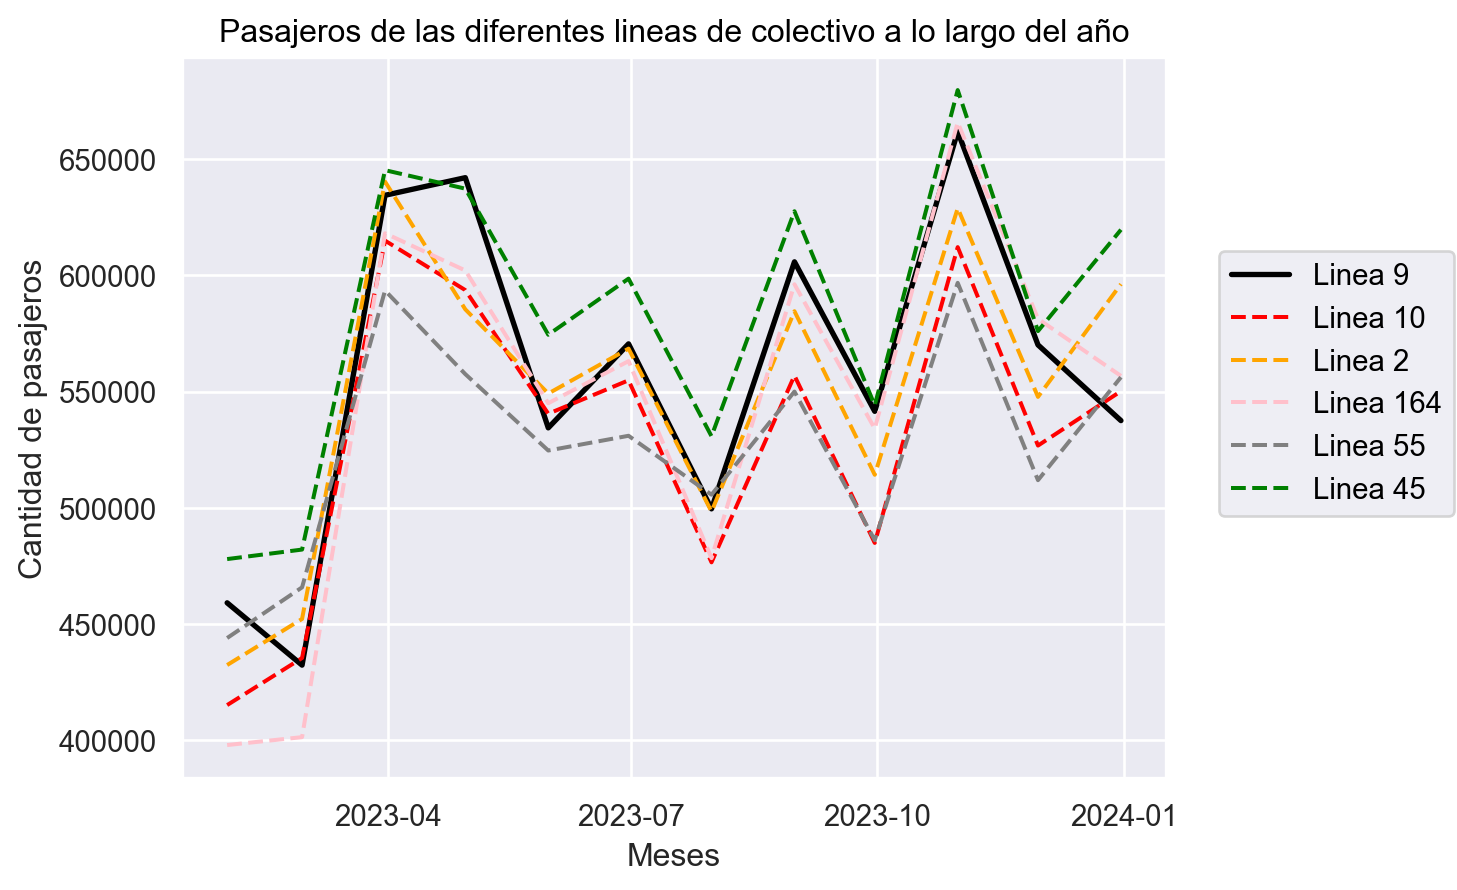

In [28]:
(
    so.Plot(data = ppl_por_mes, x = ppl_por_mes.index, y = "BSAS_LINEA_009")
    .add(so.Line(linewidth = 2, color = "black"), label = "Linea 9")
    .add(so.Line(color = "red", linestyle='--'), y = "BSAS_LINEA_010", label = "Linea 10")
    .add(so.Line(color = "orange", linestyle='--'), y = "BSAS_LINEA_002", label = "Linea 2")
    .add(so.Line(color = "pink", linestyle='--'), y = "LINEA_164_AMBA", label = "Linea 164")
    .add(so.Line(color = "grey", linestyle='--'), y = "BSAS_LINEA_055", label = "Linea 55")
    .add(so.Line(color = "green", linestyle='--'), y = "BSAS_LINEA_045", label = "Linea 45")
    .label(title = "Pasajeros de las diferentes lineas de colectivo a lo largo del año", x = "Meses" , y = "Cantidad de pasajeros")
)

Elijo esas 5 lineas de colectivo ya que como vemos en el grafico tienen una clara similitud a la linea 9 que es la que tenemos que predecir. Uso estas mismas lineas tanto en el primer modelo como en el segundo.

In [29]:
formula = "BSAS_LINEA_009 ~ BSAS_LINEA_010 + BSAS_LINEA_002 + LINEA_164_AMBA + BSAS_LINEA_055 + BSAS_LINEA_045"
y, X =  Formula(formula).get_model_matrix(pasajeros_por_linea)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo = linear_model.LinearRegression()

modelo.fit(X_train, y_train)

beta_0 = modelo.intercept_[0]
beta_1 = modelo.coef_[0][0]
beta_2 = modelo.coef_[0][1]
beta_3 = modelo.coef_[0][2]
beta_4 = modelo.coef_[0][3]
beta_5 = modelo.coef_[0][4]

y_pred = modelo.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R^2:", r2)
print("Raiz cuadarada del MSE:",rmse)

R^2: 0.9057196855583483
Raiz cuadarada del MSE: 3006.173391229385


El segundo modelo sera un modelo de regresión ridge en el cual, como dije anteriormente, utilizaré las mismas lineas de colectivo.

In [30]:
formula = "BSAS_LINEA_009 ~ BSAS_LINEA_010 + BSAS_LINEA_002 + LINEA_164_AMBA + BSAS_LINEA_055 + BSAS_LINEA_045"
y, X =  Formula(formula).get_model_matrix(pasajeros_por_linea)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

alphas = [0.001, 0.003, 0.004, 0.2, 10, 25]
for alpha in alphas:
    modelo = linear_model.Ridge(alpha = alpha, fit_intercept = False)  
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Para alpha = {alpha:.3f} la raíz del Error Cuadratico Medio es: {rmse:.2f}")

Para alpha = 0.001 la raíz del Error Cuadratico Medio es: 3006.18
Para alpha = 0.003 la raíz del Error Cuadratico Medio es: 3006.18
Para alpha = 0.004 la raíz del Error Cuadratico Medio es: 3006.19
Para alpha = 0.200 la raíz del Error Cuadratico Medio es: 3006.92
Para alpha = 10.000 la raíz del Error Cuadratico Medio es: 3021.37
Para alpha = 25.000 la raíz del Error Cuadratico Medio es: 3026.13


In [31]:
alpha_optimo = 0.004 # Hiperparametro
modelo = linear_model.Ridge(alpha = alpha_optimo, fit_intercept = False)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R^2:", r2)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Para el hiperparametro alpha = {alpha_optimo:.3f} la raíz del Error Cuadratico Medio es: {rmse:.2f}")

R^2: 0.9057187269231483
Para el hiperparametro alpha = 0.004 la raíz del Error Cuadratico Medio es: 3006.19


El último modelo de regresión lo será de regresión ridge y utilizaré lineas de colectivo que tengan un promedio ya sea mayor o menor de pasajeros que la linea 9 (mayor diferencia que en las lineas anteriores). Lo voy a graficar para un mayor entendimiento.

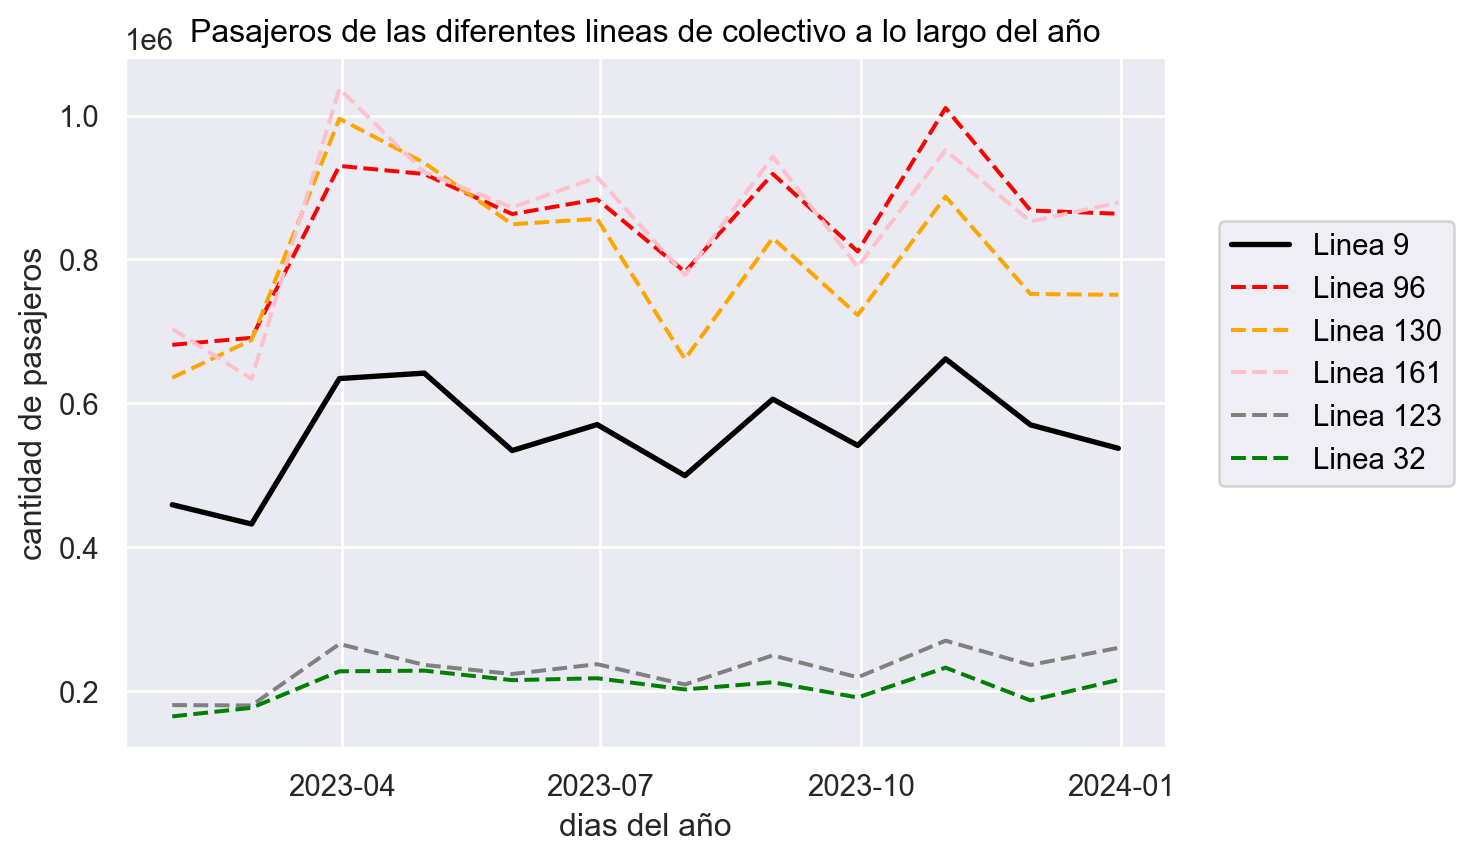

In [32]:
(
    so.Plot(data = ppl_por_mes, x = ppl_por_mes.index, y = "BSAS_LINEA_009")
    .add(so.Line(linewidth = 2, color = "black"), label = "Linea 9")
    .add(so.Line(color = "red", linestyle='--'), y = "BSAS_LINEA_096", label = "Linea 96")
    .add(so.Line(color = "orange", linestyle='--'), y = "BSAS_LINEA_130", label = "Linea 130")
    .add(so.Line(color = "pink", linestyle='--'), y = "BSAS_LINEA_161", label = "Linea 161")
    .add(so.Line(color = "grey", linestyle='--'), y = "BS_ASLINEA_123", label = "Linea 123")
    .add(so.Line(color = "green", linestyle='--'), y = "BSAS_LINEA_032", label = "Linea 32")
    .label(title = "Pasajeros de las diferentes lineas de colectivo a lo largo del año", x = "dias del año" , y = "cantidad de pasajeros")
)

In [33]:
formula = "BSAS_LINEA_009 ~ BSAS_LINEA_096 + BSAS_LINEA_130 + BSAS_LINEA_161 + BS_ASLINEA_123 + BSAS_LINEA_032"
y, X =  Formula(formula).get_model_matrix(pasajeros_por_linea)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

alphas = [0.001, 0.006, 0.007, 0.01, 1, 5, 10]
for alpha in alphas:
    modelo = linear_model.Ridge(alpha = alpha, fit_intercept = False)    
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Para alpha = {alpha:.3f} la raíz del Error Cuadratico Medio es: {rmse:.2f}")

Para alpha = 0.001 la raíz del Error Cuadratico Medio es: 2817.58
Para alpha = 0.006 la raíz del Error Cuadratico Medio es: 2817.58
Para alpha = 0.007 la raíz del Error Cuadratico Medio es: 2817.59
Para alpha = 0.010 la raíz del Error Cuadratico Medio es: 2817.59
Para alpha = 1.000 la raíz del Error Cuadratico Medio es: 2818.27
Para alpha = 5.000 la raíz del Error Cuadratico Medio es: 2821.12
Para alpha = 10.000 la raíz del Error Cuadratico Medio es: 2824.27


In [34]:
alpha_optimo = 0.006 # Hiperparametro
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo = linear_model.Ridge(alpha = alpha_optimo, fit_intercept = False)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R^2:", r2)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Para el hiperparametro alpha = {alpha_optimo:.3f} la raíz del Error Cuadratico Medio es: {rmse:.2f}")

R^2: 0.9171777756502327
Para el hiperparametro alpha = 0.006 la raíz del Error Cuadratico Medio es: 2817.58


Notemos como en los resultados del R2 y de la raíz del Error Cuadratico Medio el mejor modelo es el tercero, dado que cuenta con un R2 mayor (0,92 aprox.) y con la raíz del Error Cuadratico Medio más pequeño (2818 aprox.). Luego, elijo la fórmula final del modelo.

In [35]:
formula = "BSAS_LINEA_009 ~ BSAS_LINEA_096 + BSAS_LINEA_130 + BSAS_LINEA_161 + BSAS_LINEA_123 + BSAS_LINEA_032"

### Limitaciones

El análisis se basa en datos agregados y no incorpora factores externos como clima o eventos, lo que limita la capacidad predictiva del modelo.
